# Implementing the trajectory of the ball throw with noisy and hidden observations

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

def convert_rad_to_degree(angle):
    return (angle*np.pi)/180

def ball_throw_trajectory(launch_speed,angle,height,dt,total_time,g=9.81):
    theta_0 = angle
    v_0 = launch_speed
    h_0 = height
    time_sim = total_time
    step_size = dt
    samples = int(time_sim/step_size)
    time = np.linspace(0,time_sim,samples)
    vx_0 = np.cos(convert_rad_to_degree(theta_0))*v_0
    vy_0 = np.sin(convert_rad_to_degree(theta_0))*v_0

    # Adding the wall to the trajectory and the ball's direction change on impact
    x = []
    for idx in range(time.shape[0]):
      if idx < 35:
        x.append(vx_0 * time[idx])
      else:
        x.append(x[-1] - (vx_0 * step_size))
    x = np.array(x)

    y = vy_0*time-g*time**2*0.5+h_0
    vx = np.repeat(vx_0,samples)
    vy = vy_0-g*time
    signal = np.stack((x,y,vx,vy))
    return(signal,time)

def add_noise_to_observations(signal,mu,sd):
    noise = np.random.multivariate_normal(mu,sd,signal.shape[1]).T
    signal_n = signal + noise

    return signal_n

def hide_observations(signal,t_0,duration,dt,error_value = -999999):
    i_begin = int(t_0/dt)-1
    i_final = i_begin + int(duration/dt)+1
    signal_m = signal.copy()
    # Set the values to the error_value for the part that should be hidden
    signal_m[1,i_begin:i_final] = error_value
    return signal_m

### Plotting the trajectory of the ball and the observations

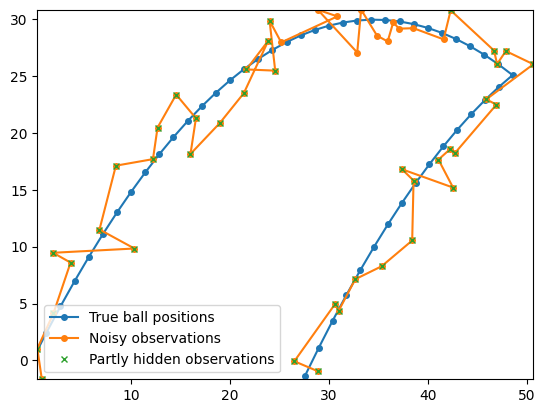

In [115]:
# Configuration of the trajectory and observations
dt = 0.1
launch_speed = 28
angle = 60
height = 0
time_simulation = 5
signal_real, time = ball_throw_trajectory(launch_speed,
                                          angle,
                                          height,
                                          dt,
                                          time_simulation
                                          )
positions_real = signal_real[[0,1]]

# Add noise to the observations
mu_noise = [0,0]
cov_noise = [[2,0],[0,2]]
noisy_observations = add_noise_to_observations(positions_real, mu_noise, cov_noise)

# Hide some of the observations
hidden_start = 2
hidden_duration = 1
hidden_time_step = 0.1
noisy_hidden_observations = hide_observations(noisy_observations,
                                              hidden_start,
                                              hidden_duration,
                                              hidden_time_step
                                              )

# Which datapoints to display on the plot
plt.plot(positions_real[0], positions_real[1],'o',ls = '-',markersize = 4, label="True ball positions")
plt.plot(noisy_observations[0],noisy_observations[1],'o',ls = '-',markersize = 4, label="Noisy observations")
plt.plot(noisy_hidden_observations[0],noisy_hidden_observations[1],'x',markersize = 4, label="Partly hidden observations")

# Make Plot look nicer
min_y = min(noisy_observations[1])
min_x = min(noisy_observations[0])
max_y = max(noisy_observations[1])
max_x = max(noisy_observations[0])
plt.ylim(min_y, max_y)
plt.xlim(min_x, max_x)
plt.legend()
plt.show()

# Kalman filter

In [116]:
class KalmanFilter(object):
    def __init__(self, dt, g = 9.81,initial_state = np.matrix([[0,0,0,0]]).T,Q = np.diag([1,1,1,1]),R = np.diag([1,1])):
        self.dt = dt
        self.u = np.matrix([0,g,0]).T
        self.x = initial_state
        # State Transition
        self.A = np.matrix([[1, 0, self.dt, 0],
                            [0, 1, 0, self.dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])
        # Control Input Matrix
        self.B = np.matrix([[0,0,0],
                            [0,-0.5*self.dt**2,0],
                            [0,0,0],
                            [0,-self.dt,0]])
        # Measurement Mapping Matrix
        self.H = np.matrix([[1, 0, 0, 0],
                            [0, 1, 0, 0]])
        # Initial Process Noise Covariance
        self.Q = Q
        # Initial Measurement Noise Covariance
        self.R = R
        # Initial Covariance Matrix
        self.P = np.eye(self.A.shape[1])

    def predict(self):
        # Refer to :Eq.(9) and Eq.(10)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # Update time state
        # x_k =Ax_(k-1) + Bu_(k-1)     Eq.(9)
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Calculate error covariance
        # P= A*P*A' + Q               Eq.(10)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x[0:2]

    def update(self, z):
        # Refer to :Eq.(11), Eq.(12) and Eq.(13)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  #Eq.(11)
        self.x = self.x + np.dot(K, (z - np.dot(self.H, self.x)))  #Eq.(12)
        I = np.eye(self.H.shape[1])
        # Update error covariance matrix
        self.P = (I - (K * self.H)) * self.P   #Eq.(13)
        return self.x[0:2]

### Applying the Kalman filter to ball throw with walls

50
-0.6857042612352345 31.042781036993954
-0.6686238207848075 49.3011509039156


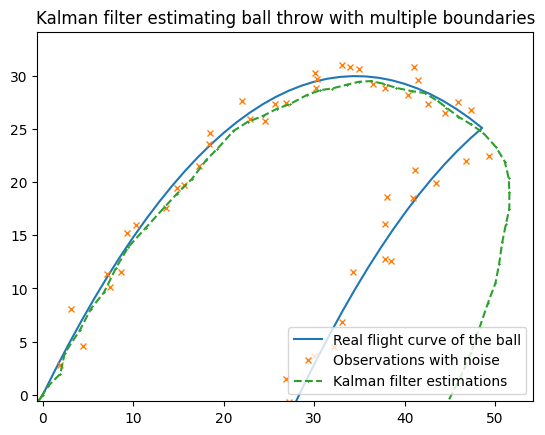


Hidden observation.
Hidden observation.
Hidden observation.
Hidden observation.
Hidden observation.
Hidden observation.
Hidden observation.
Hidden observation.
Hidden observation.
Hidden observation.
Hidden observation.
-0.6857042612352345 31.042781036993954
-0.6686238207848075 49.3011509039156


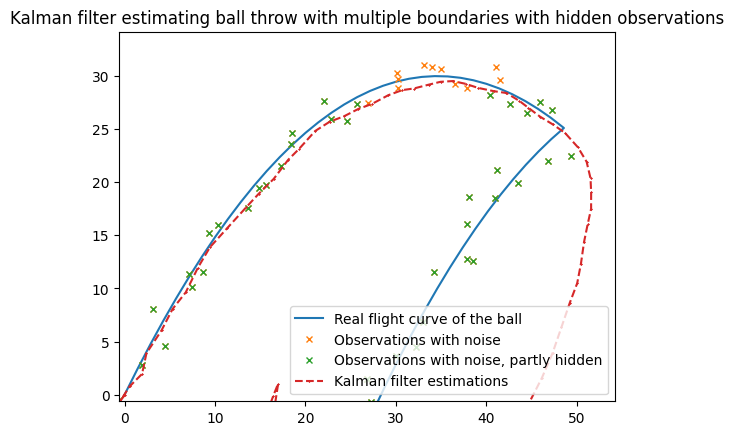

In [117]:
error_value = -999999
g = 9.81
dt = 0.1
duration_simulation = 5
height = 0
speed = 28
angle = 60
signal_real, time = ball_throw_trajectory(speed,
                                      angle,
                                      height,
                                      dt,
                                      duration_simulation,
                                      )
positions_real = signal_real[[0,1]]

mu_noise = [0,0]
cov_noise = [[1,0],[0,1]]
noisy_observations = add_noise_to_observations(positions_real,mu_noise,cov_noise)

hidden_start = 2
hidden_duration = 1
noisy_hidden_observations = hide_observations(noisy_observations,
                             hidden_start,
                             hidden_duration,
                             dt,
                             error_value=error_value
                             )

x_init = np.matrix([[0],[0],[0],[0]])
Q = np.diag([0.001,0.001,0.001,0.001])
R = np.diag([0.5,0.3])
KF = KalmanFilter(dt,g,initial_state=x_init,Q=Q,R=R)

print(len(time))
x_f = []
y_f = []

for n in range(len(["noisy_observaitons", "hidden_noisy_observations"])):
  for i in range(len(time)):
      x_o = positions_real[0,i]
      y_o = positions_real[1,i]

      x_n = []
      y_n = []
      if n == 0: # First apply the Kalman filter without hidden observations
        x_n = noisy_observations[0,i]
        y_n = noisy_observations[1,i]
      elif n == 1: # Next apply the Kalman filter with hidden observations
        x_n = noisy_hidden_observations[0,i]
        y_n = noisy_hidden_observations[1,i]

      if y_n == error_value:
          print('Hidden observation.')
          x_n = float(x1)
          y_n = float(y1)

      pos = np.matrix([x_n,y_n]).T
      # Predict
      (x, y) = KF.predict()
      # Update
      (x1, y1) = KF.update(pos)
      x_f.append(float(x))
      y_f.append(float(y))
  f_pos = np.stack((x_f,y_f))

  plt.plot(positions_real[0], positions_real[1],ls = '-',markersize = 1,label = 'Real flight curve of the ball')
  plt.plot(noisy_observations[0], noisy_observations[1],'x',markersize = 4, label = 'Observations with noise')
  if n == 1:
    plt.plot(noisy_hidden_observations[0], noisy_hidden_observations[1],'x',markersize = 4, label = 'Observations with noise, partly hidden')
  plt.plot(f_pos[0],f_pos[1],'x',ls = '--',markersize = 1,label = 'Kalman filter estimations')

  if n == 0:
    plt.title("Kalman filter estimating ball throw with multiple boundaries")
  elif n == 1:
    plt.title("Kalman filter estimating ball throw with multiple boundaries with hidden observations")
  plt.legend(loc="lower right")

  min_y = min(noisy_observations[1])
  min_x = min(noisy_observations[0])
  max_y = max(noisy_observations[1])
  max_x = max(noisy_observations[0])
  print(min_y,max_y)
  print(min_x,max_x)
  plt.ylim(min_y-min_y*0.1,max_y+0.1*max_y)
  plt.xlim(min_x-min_x*0.1,max_x+0.1*max_x)
  plt.show()
  print()


### Calculating the error of estimation for specific parts of the throw (for the paper)

In [118]:
# Calculating estimation error

distances = 0
for i in range(positions_real.shape[1]):
  if i >= 35:
    continue

  x_distance = positions_real[0, i] - f_pos[0, i]
  y_distance = positions_real[1, i] - f_pos[1, i]
  distance = np.sqrt(x_distance**2 + y_distance**2)
  distances += distance
print("after time step 35:", distance)

after time step 35: 1.3104253217998925


# Particle Filter
- Now 2 balls are thrown and the position and velocity of both should be estimated
- The implementations should have the same parameters as the kalman filter

### Creating and plotting the trajectories of two ball throws

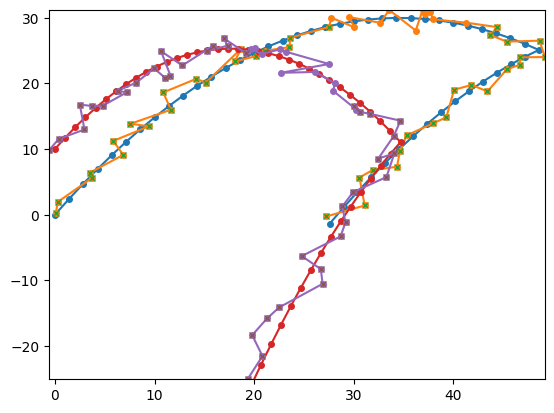

In [119]:
# Create noisy observations of 2 balls

# ball 1
dt = 0.1
time_sim = 5
launch_speed_1 = 28
angle_1 = 60
height_1 = 0
signal_real_1, time = ball_throw_trajectory(launch_speed_1,
                                         angle_1,
                                         height_1,
                                         dt,
                                         time_sim
                                         )

real_positions_1 = signal_real_1[[0,1]]

mu_1_noise = [0,0]
cov_1_noise = [[1,0],[0,1]]
noisy_observations_1 = add_noise_to_observations(real_positions_1, mu_1_noise, cov_1_noise)
noisy_hidden_observations_1 = hide_observations(noisy_observations_1, 2, 1, 0.1)


# ball 2
launch_speed_2 = 20
angle_2 = 60
height_2 = 10
real_signal_2, time = ball_throw_trajectory(launch_speed_2,angle_2,height_2,dt,5)
real_positions_2 = real_signal_2[[0,1]]

mu_2_noise = [0,0]
cov_2_noise = [[1,0],[0,1]]
noisy_observations_2 = add_noise_to_observations(real_positions_2, mu_2_noise, cov_2_noise)
noisy_hidden_observations_2 = hide_observations(noisy_observations_2, 2, 1, 0.1)

# Combining the array of the two balls to one array
real_signal = np.array([signal_real_1, real_signal_2])
real_positions = real_signal[:, [0,1]]
noisy_observations = np.array([noisy_observations_1, noisy_observations_2])
noisy_hidden_observations = np.array([noisy_hidden_observations_1, noisy_hidden_observations_2])

# Plotting both balls
plt.plot(real_positions[0][0],real_positions[0][1],'o',ls = '-',markersize = 4)
plt.plot(noisy_observations[0][0],noisy_observations[0][1],'o',ls = '-',markersize = 4)
plt.plot(noisy_hidden_observations[0][0],noisy_hidden_observations[0][1],'x',markersize = 4)

plt.plot(real_positions[1][0],real_positions[1][1],'o',ls = '-',markersize = 4)
plt.plot(noisy_observations[1][0],noisy_observations[1][1],'o',ls = '-',markersize = 4)
plt.plot(noisy_hidden_observations[1][0],noisy_hidden_observations[1][1],'x',markersize = 4)

# Making the plots look nicer
noisy_observations_combined_x = np.concatenate((noisy_observations[0][0], noisy_observations[1][0]))
noisy_hidden_observations_combined_y = np.concatenate((noisy_observations[0][1], noisy_observations[1][1]))
min_y = min(noisy_hidden_observations_combined_y)
min_x = min(noisy_observations_combined_x)
max_y = max(noisy_hidden_observations_combined_y)
max_x = max(noisy_observations_combined_x)
plt.ylim(min_y, max_y)
plt.xlim(min_x, max_x)

plt.show()

In [154]:
print(noisy_observations.shape)

(2, 2, 50)


### Particle filter Implementation for 2 balls

In [176]:
import scipy

def initialize_particles_gaussian_noise(x_pos, y_pos, x_vel, y_vel, num_particles=100, std=1):
  # Create num_particles with known pos and vel and add normal distributed noise to them
  particles = np.empty((num_particles, 4))
  particles[:, 0] = np.random.normal(x_pos, 1, num_particles)
  particles[:, 1] = np.random.normal(y_pos, 1, num_particles)
  particles[:, 2] = np.random.normal(x_vel, 1, num_particles)
  particles[:, 3] = np.random.normal(y_vel, 1, num_particles)
  return particles

# prediction step
def state_transition(particle, time_step, signal, observation_idx, ball_idx, g=9.81):
  # You can do this because the balls trajactory used to create the observations is the same trajactory that should be used here in the state transition
  # The particle array and the prediction step are equivalent, that's why it can be used here
  new_x = particle[0] + particle[2]
  new_y = particle[1] + particle[3]

  # able to use signal information in the case where the system dynamics are known for the state transition, since it's equivalent
  new_xv = signal[ball_idx][0][observation_idx] - particle[0]
  new_yv = signal[ball_idx][1][observation_idx] - particle[1]

  new_particle = [new_x, new_y, new_xv, new_yv]
  return new_particle

# control step
def particle_evaluation(particle, shaky_observation, weight):
  # Calculate likelihood of observation for normal distribution around particle. Set that as weight.
  likelihood = scipy.stats.norm(shaky_observation[0:2], 1).pdf(particle[0:2])
  weight = likelihood[0] + likelihood[1]
  return weight

def resampling(particles, weights):
  resampled_particles = []
  for ball_idx in range(2):
    mean = np.average(particles[ball_idx], weights=weights[ball_idx], axis=0)
    resampled_particles.append(initialize_particles_gaussian_noise(mean[0], mean[1], mean[2], mean[3]))
  return np.array(resampled_particles)

def particle_filter(initial_particles, signal_shaky, signal_real, time_sim, step_size):
  samples = int(time_sim/step_size)
  time = np.linspace(0,time_sim,samples)


  particles = initial_particles.copy()
  num_observations = signal_shaky.shape[2]
  num_particles = particles.shape[1]
  num_balls = 2
  weights = np.array(
      [np.ones(num_particles) / num_particles,
      np.ones(num_particles) / num_particles]
  ) # Intialize uniformly.
  estimated_states = []

  for observation_idx in range(num_observations): # Go through all of the observations
    if observation_idx % 5 == 0: # Just for logging
      print("observation_idx:", observation_idx)

    # Resample particles
    particles = resampling(particles, weights)

    # Prediction step
    for particle_idx in range(num_particles): # Go through all of the particles
      for ball_idx in range(num_balls):
        # Calcuate the new positions and velocities for each of the particles seperately
        time_step = time[observation_idx]
        particles[ball_idx][particle_idx] = state_transition(particles[ball_idx][particle_idx], time_step, signal_shaky, observation_idx, ball_idx)

    # Evaluation step
    for particle_idx in range(num_particles):
      for ball_idx in range(num_balls):
        # Look at the position and velocity of each of the partilces and calculate their weights, based on how far they are away from the shaky observation
        signal = signal_shaky[ball_idx, :, observation_idx]
        weights[ball_idx][particle_idx] = particle_evaluation(particles[ball_idx][particle_idx], signal, weights[ball_idx][particle_idx])

    # Normalize weights
    weights /= np.sum(weights)

    # Estimated state
    estimated_state_1 = np.average(particles[0], weights=weights[0], axis=0)
    estimated_state_2 = np.average(particles[1], weights=weights[1], axis=0)
    estimated_states.append([estimated_state_1, estimated_state_2])

  return np.array(estimated_states)

# ball 1
x_start = 0
y_start = 0
initial_particles = [initialize_particles_gaussian_noise(x_start,y_start,0.1,0.1)]

# ball 2
x_start = 0
y_start = 10
initial_particles.append(initialize_particles_gaussian_noise(x_start,y_start,0.1,0.1))
initial_particles = np.array(initial_particles)

# Particle filter
dt = 0.1
time_sim = 5
estimated_states = particle_filter(initial_particles, noisy_observations, real_signal, time_sim=time_sim, step_size=dt)


observation_idx: 0
observation_idx: 5
observation_idx: 10
observation_idx: 15
observation_idx: 20
observation_idx: 25
observation_idx: 30
observation_idx: 35
observation_idx: 40
observation_idx: 45


### Plotting Particle filter for 2 balls

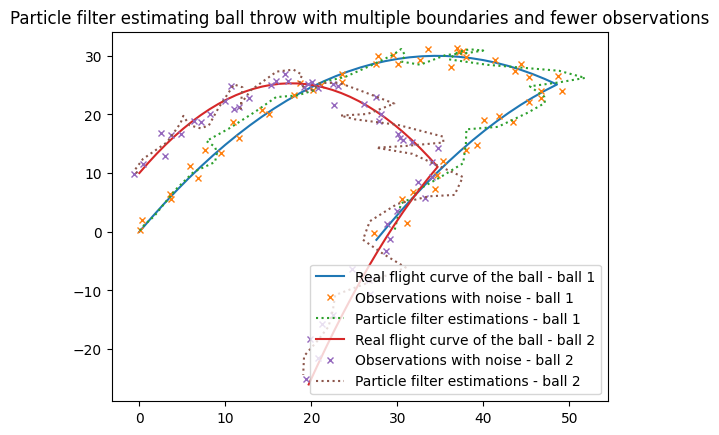

In [177]:
x_estimated_1 = estimated_states[:, 0, 0]
y_estimated_1 = estimated_states[:, 0, 1]

x_estimated_2 = estimated_states[:, 1, 0]
y_estimated_2 = estimated_states[:, 1, 1]

plt.plot(real_signal[0, 0, :],real_signal[0, 1, :],ls = '-',markersize = 1,label = 'Real flight curve of the ball - ball 1')
plt.plot(noisy_observations[0, 0, :], noisy_observations[0, 1, :],'x',markersize = 4,label = 'Observations with noise - ball 1')
plt.plot(x_estimated_1,y_estimated_1,ls = ':',markersize = 1,label = 'Particle filter estimations - ball 1')

plt.plot(real_signal[1, 0, :],real_signal[1, 1, :],ls = '-',markersize = 1,label = 'Real flight curve of the ball - ball 2')
plt.plot(noisy_observations[1, 0, :], noisy_observations[1, 1, :], 'x',markersize = 4,label = 'Observations with noise - ball 2')
plt.plot(x_estimated_2, y_estimated_2, ls = ':',markersize = 1,label = 'Particle filter estimations - ball 2')

plt.title("Particle filter estimating ball throw with multiple boundaries and fewer observations")
plt.legend()
plt.show()

### Implementation of the Particle filter with only one ball (for the paper)

In [179]:
import scipy

def initialize_particles_gaussian_noise(x_pos, y_pos, x_vel, y_vel, num_particles=100, std=1):
  # Create num_particles with known pos and vel and add normal distributed noise to them
  particles = np.empty((num_particles, 4))
  particles[:, 0] = np.random.normal(x_pos, 1, num_particles)
  particles[:, 1] = np.random.normal(y_pos, 1, num_particles)
  particles[:, 2] = np.random.normal(x_vel, 1, num_particles)
  particles[:, 3] = np.random.normal(y_vel, 1, num_particles)
  return particles

# prediction step
def state_transition(particle, time_step, signal, observation_idx, g=9.81):
  # You can do this because the balls trajactory used to create the observations is the same trajactory that should be used here in the state transition
  # The particle array and the prediction step are equivalent, that's why it can be used here
  new_x = particle[0] + particle[2]
  new_y = particle[1] + particle[3]

  # able to use signal information in the case where the system dynamics are known for the state transition, since it's equivalent
  new_xv = signal[0][observation_idx] - particle[0]
  new_yv = signal[1][observation_idx] - particle[1]

  new_particle = [new_x, new_y, new_xv, new_yv]
  return new_particle

# control step
def particle_evaluation(particle, shaky_observation, weight):
  # Calculate likelihood of observation for normal distribution around particle. Set that as weight.
  likelihood = scipy.stats.norm(shaky_observation[0:2], 1).pdf(particle[0:2])
  weight = likelihood[0] + likelihood[1]
  return weight

def resampling(particles, weights):
  mean = np.average(particles, weights=weights, axis=0)
  resampled_particles = initialize_particles_gaussian_noise(mean[0], mean[1], mean[2], mean[3])
  return resampled_particles

def particle_filter(initial_particles, signal_shaky, signal_real, time_sim, step_size):
  samples = int(time_sim/step_size)
  time = np.linspace(0,time_sim,samples)

  particles = initial_particles.copy()
  print(particles.shape)
  num_observations = len(signal_shaky[1])
  num_particles = particles.shape[0]
  weights = np.ones(num_particles) / num_particles # Intialize uniformly.
  print(weights.shape)
  estimated_states = []

  for observation_idx in range(num_observations): # Go through all of the observations
    if observation_idx % 5 == 0: # Just for logging
      print("observation_idx:", observation_idx)

    # Resample particles
    particles = resampling(particles, weights)

    # Prediction step
    for particle_idx in range(num_particles): # Go through all of the particles
      # Calcuate the new positions and velocities for each of the particles seperately
      time_step = time[observation_idx]
      particles[particle_idx] = state_transition(particles[particle_idx], time_step, signal_shaky, observation_idx)

    # Evaluation step
    for particle_idx in range(num_particles):
      # Look at the position and velocity of each of the partilces and calculate their weights, based on how far they are away from the shaky observation
      signal = signal_shaky[:, observation_idx]
      weights[particle_idx] = particle_evaluation(particles[particle_idx], signal, weights[particle_idx])

    # Normalize weights
    weights /= np.sum(weights)

    # Estimated state
    estimated_state = np.average(particles, weights=weights, axis=0)
    estimated_states.append(estimated_state)

  return np.array(estimated_states)


launch_speed_1 = 28
angle_1 = 60
height_1 = 0
x_start = 0
y_start = 0

initial_particles = initialize_particles_gaussian_noise(x_start,y_start,0.1,0.1)

dt = 0.1
time_sim = 5

real_signal_1 = real_signal[0] # only look at ball 1
noisy_observations_1 = noisy_observations[0] # only look at ball 1

estimated_states = particle_filter(initial_particles, noisy_observations_1, real_signal_1, time_sim=time_sim, step_size=dt)


(100, 4)
(100,)
observation_idx: 0
observation_idx: 5
observation_idx: 10
observation_idx: 15
observation_idx: 20
observation_idx: 25
observation_idx: 30
observation_idx: 35
observation_idx: 40
observation_idx: 45


### Applying and plotting Particle filter (for the paper)

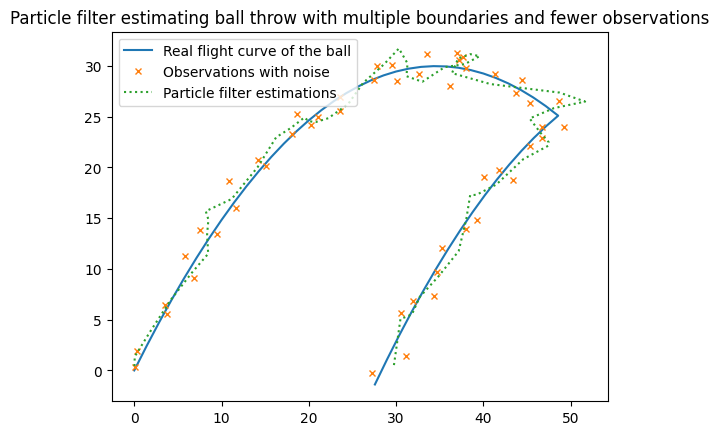

In [180]:
x_estimated_1 = estimated_states[:, 0]
y_estimated_1 = estimated_states[:, 1]

plt.plot(signal_real_1[0], signal_real_1[1], ls = '-', markersize = 1, label = 'Real flight curve of the ball')
plt.plot(noisy_observations_1[0], noisy_observations_1[1], 'x', markersize = 4, label = 'Observations with noise')
plt.plot(estimated_states[:,0], estimated_states[:,1], ls = ':', markersize = 1, label = 'Particle filter estimations')
plt.title("Particle filter estimating ball throw with multiple boundaries and fewer observations")
plt.legend()
plt.show()